In [2]:
import pandas as pd


def format_pd(data, intento):

    data = data[data["Intento"] == intento].copy() 

    # Esto es para que arranque en 365 una vez (lo hizo chat obviamente)
    mask = (data['x'] != 365.00) | (data['x'].shift(-1) != 365.00)

    data = data[mask]

    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].min()

    data = data.drop(columns=["Intento"])
    
    return data

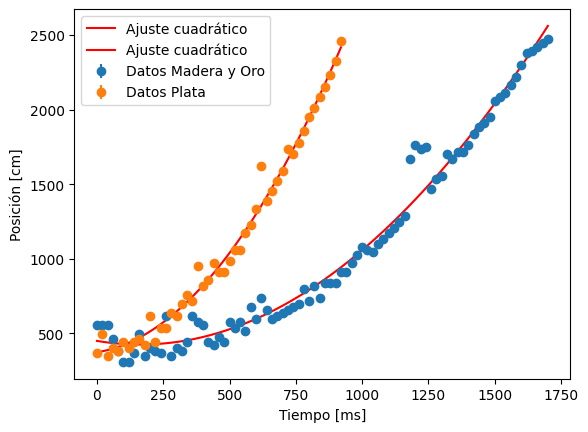

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

datasets = ['data_maderayoro_dosplata.csv', 'data_plata_dosplata.csv'] 

for dataset in datasets:
    if datasets.index(dataset) == 0:
        name = "Madera y Oro"
    else:
        name = "Plata"
    data = pd.read_csv(dataset)

    f_data = format_pd(data=data, intento=1)


    tiempo = f_data["t"].values
    posicion = f_data["x"].values
    errores_y =  1
    errores_x = 1


    # Definir la función cuadrática con v_0 = 0
    def modelo_cuadratico(t, a, v_0, x_0):
        return a * t**2 + v_0 * t +  x_0

    # Ajustar la curva
    popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

    # Obtener los coeficientes ajustados y sus errores
    a_opt, v_0_opt, x_0_opt = popt
    errores = np.sqrt(np.diag(pcov))

    # Graficar los datos y el ajuste
    t_ajuste = np.linspace(tiempo.min(), tiempo.max(), 100)
    plt.errorbar(tiempo, posicion, yerr=errores_y, fmt='o', label=f'Datos {name}')

    plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'r', label=f'Ajuste cuadrático')
plt.xlabel('Tiempo [ms]')
plt.ylabel('Posición [cm]')
plt.legend()
plt.show()
